In [1]:
import WaveLSTM
# Data modules
import TCGA
from SignalTransformData.data_modules.simulated import SinusoidalDataModule
# Other
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch



Global seed set to 42


In [3]:
# create and encoder module - we won't use it to encode, but need the masking function
dm = "demo"
if dm == "ascat":
    channels = 2
    chromosomes = 23
    encoder = WaveLSTM.modules.encoder.Encoder(90, channels, chromosomes)

    # Create data module that we want to plot
    dm = TCGA.data_modules.ascat.ASCATDataModule(batch_size=128, 
                                                 cancer_types=['OV', 'GBM', 'KIRC', 'HNSC', 'LGG'],
                                                )
    
elif dm == "demo":
    seq_length = 512
    channels = 2
    chromosomes = 1
    encoder = WaveLSTM.modules.encoder.Encoder(seq_length, channels, chromosomes,
                                               wavelet="haar",
                                               recursion_limit=None)
    pool = torch.nn.AvgPool1d(encoder.max_resolution, encoder.max_resolution)
    
    config = {
        "bias": [[-0.5, 0.5],
                 [0.5, -0.5],
                 [-0.5, 0.5],
                 [-0.5, 0.5],
                 [0, 0],
                 [0, 0]],
        "base_angular_freq": [[1 * np.pi, 2 * np.pi],
                              [1 * np.pi, 2 * np.pi],
                              [1 * np.pi, 1 * np.pi],
                              [1 * np.pi, 1 * np.pi],
                              [3 * np.pi, 2 * np.pi],
                              [3 * np.pi, 2 * np.pi]],
        "base_amplitude": [[0.5, 0.5],
                           [0.5, 0.5],
                           [0.0, 0.5],
                           [0.0, 0.5],
                           [0.5, 0.5],
                           [0.5, 0.5]],
        "transient_bool": [False, False, False, True, False, False],
        "transient_start": [[np.NaN, np.NaN],
                            [np.NaN, np.NaN],
                            [np.NaN, np.NaN],
                            [125, 250],
                            [np.NaN, np.NaN],
                            [np.NaN, np.NaN]],
        "transient_amplitude": [[np.NaN, np.NaN],
                                [np.NaN, np.NaN],
                                [np.NaN, np.NaN],
                                [0.15, -0.15],
                                [np.NaN, np.NaN],
                                [np.NaN, np.NaN]],
        "singularity_bool": [False, False, False, False, False, True],
        "singularity_start": [[np.NaN, np.NaN],
                              [np.NaN, np.NaN],
                              [np.NaN, np.NaN],
                              [np.NaN, np.NaN],
                              [np.NaN, np.NaN],
                              [50, 300]],
        "singularity_amplitude": [[np.NaN, np.NaN],
                                  [np.NaN, np.NaN],
                                  [np.NaN, np.NaN],
                                  [np.NaN, np.NaN],
                                  [np.NaN, np.NaN],
                                  [-0.3, 0.3]],
    }
    
    dm = SinusoidalDataModule(config, samples=2000, batch_size=64, sig_length=seq_length)
else:
    raise NotImplementedError

9
resolution 1, C 0, H 0


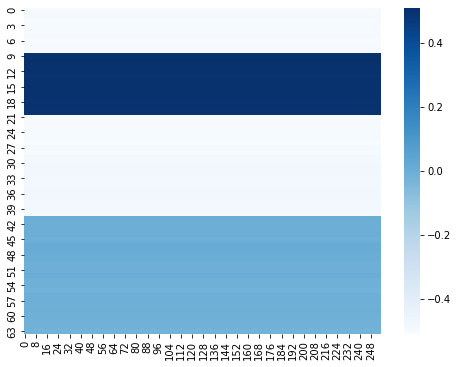

resolution 1, C 1, H 0


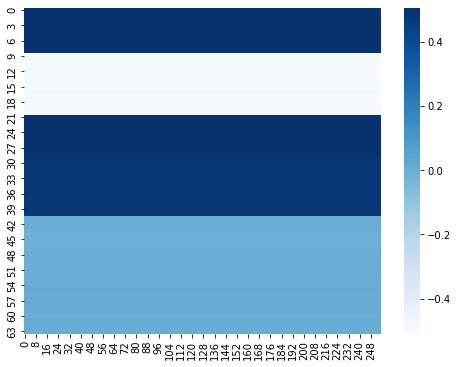

resolution 2, C 0, H 0


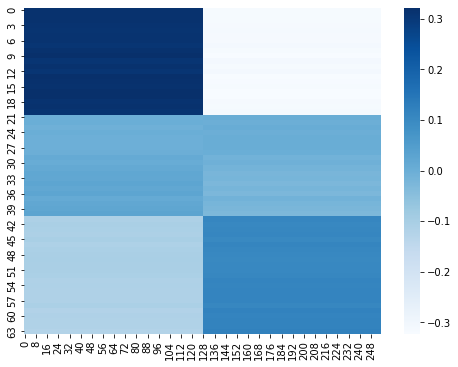

resolution 2, C 1, H 0


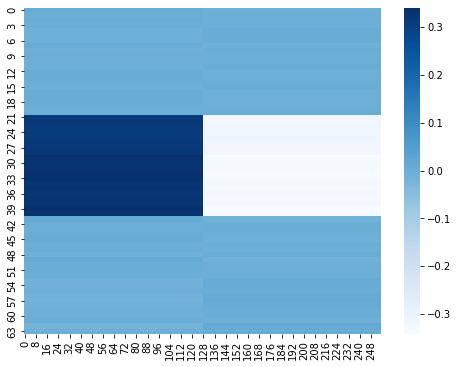

resolution 3, C 0, H 0


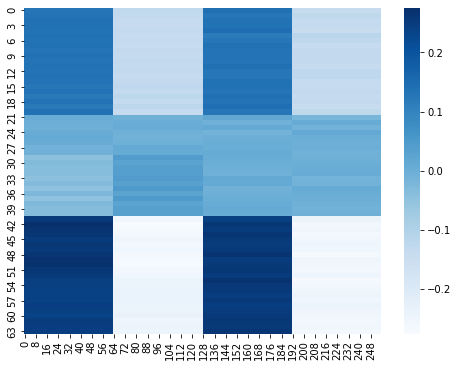

resolution 3, C 1, H 0


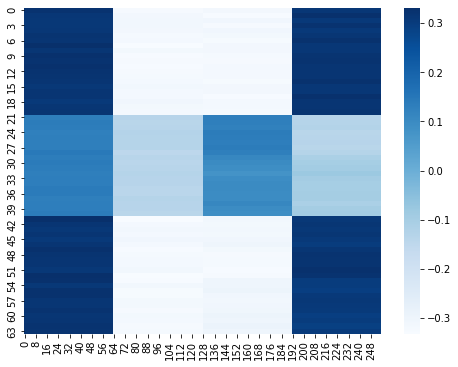

resolution 4, C 0, H 0


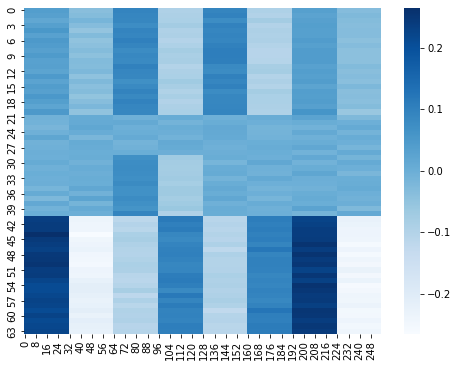

resolution 4, C 1, H 0


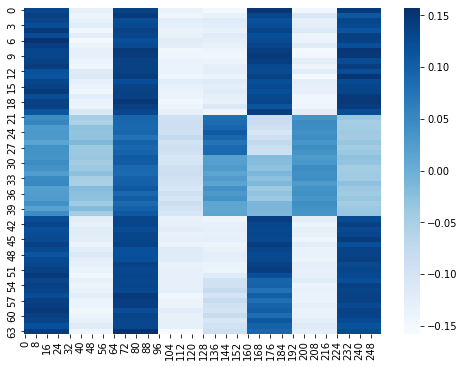

resolution 5, C 0, H 0


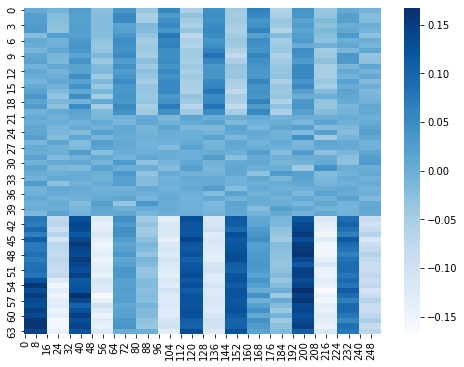

resolution 5, C 1, H 0


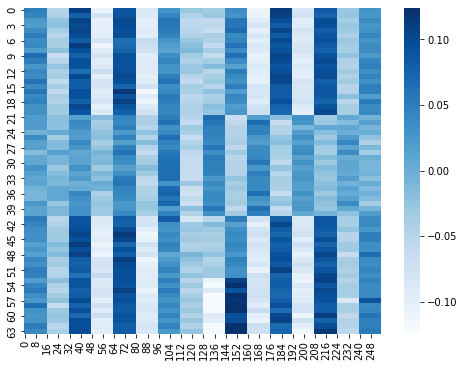

resolution 6, C 0, H 0


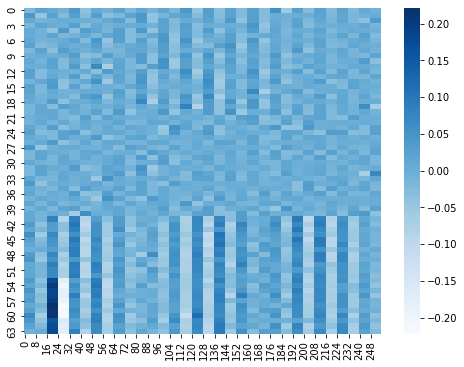

resolution 6, C 1, H 0


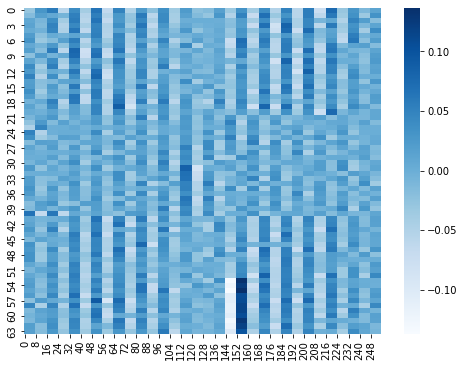

resolution 7, C 0, H 0


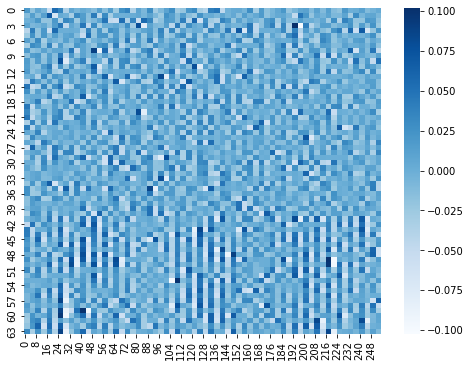

resolution 7, C 1, H 0


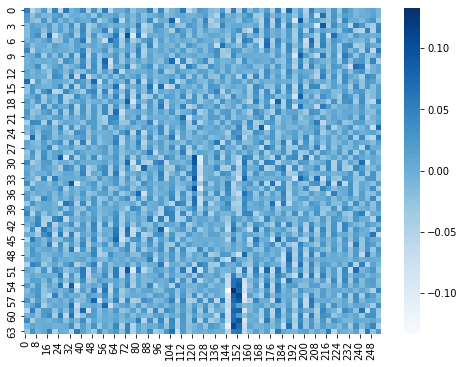

resolution 8, C 0, H 0


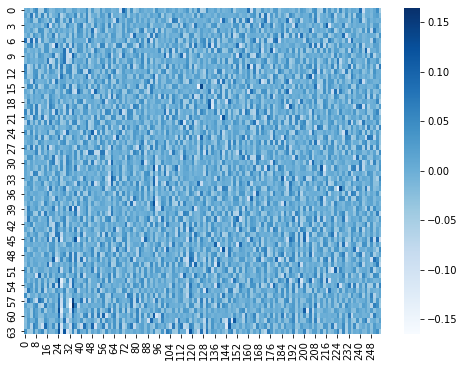

resolution 8, C 1, H 0


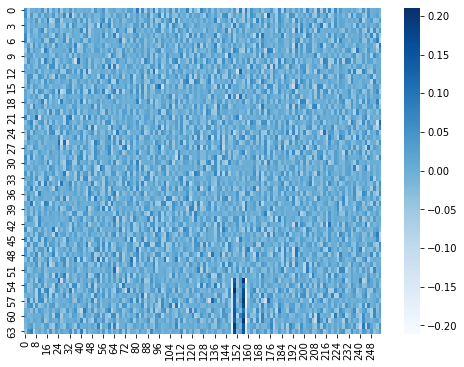

resolution 9, C 0, H 0


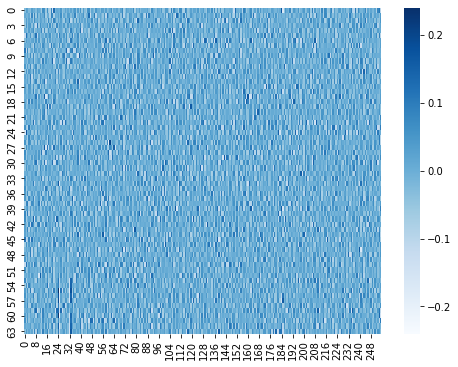

resolution 9, C 1, H 0


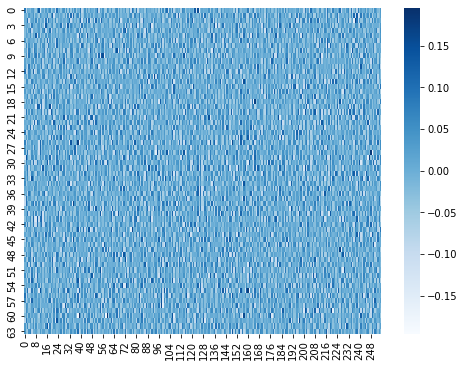

In [4]:
for batch in dm.test_dataloader():
        
    x = batch['feature']
    labels = batch['label'].cpu()
    
    if x.dim() == 3:
        x = x.unsqueeze(2)

    # Order by label for plotting
    permute_idx = np.argsort(labels)
    x = x[permute_idx, :, :]
    labels = labels[permute_idx]

    # Get the masked input,
    #  for example, residual + right masking gives xmask_\j = x - IWT(\alpha_1, \alpha_\j, 0, \dots)
    #               no residual + masking both directions gives xmask_\j = IWT(0, \alpha_\j, 0, \dots)
    masked_inputs = encoder.masked_input(x, residual=False, mask="both")
    print(len(masked_inputs))

    for j, m in enumerate(masked_inputs):
        xj_in = m.cpu()
        
        for c in range(xj_in.shape[1]):
            for h in range(xj_in.shape[2]):
                print(f"resolution {j+1}, C {c}, H {h}")
                
                xj_in_chan = xj_in[:, c, h, :]
                
                xj_in_chan = pool(xj_in_chan).cpu()
                
                vmax_res = np.min((5, xj_in_chan.max()))
                vmin_res = np.min((1, xj_in_chan.min()))
        
                fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 6)) 
                sns.heatmap(xj_in_chan, cmap='Blues', ax=ax1, vmin=vmin_res, vmax=vmax_res)    
                plt.show()
        
    break